Lab Work 5

1. Load the manipulator model from the toolbox according to the selected robot kinematics variant.  
2. Fill in all parameters of the robot model in accordance with Laboratory Work №1.  
3. Set the desired trajectory of the manipulator's motion according to Laboratory Work №2.  
4. Create a robot control system model implementing regulation based on the inverse dynamics model. It is recommended to synthesize a PD-controller (other controllers are also acceptable).  
5. Tune the controller coefficients to minimize the error of the generalized joint coordinates.  
6. Plot the position, velocity, and torque for each robot joint during the trajectory motion.  
7. Add a payload and repeat steps № 5–6.  
8. Prepare a report in .ipynb format with detailed comments. Formulate conclusions based on the work results.

1. Importing the library and loading the model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH, jtraj
from spatialmath import SE3
from IPython.display import display
from math import pi
from matplotlib import animation
from IPython.display import display

2. Creating an UR3 model with dynamic parameters

UR3 Link Parameters (standard configuration)

In [3]:
mm = 0.001
class UR3Robot:
    def __init__(self, payload_mass=0.0, payload_com=np.array([0, 0, 0.1])):
        self.links = [
            {   # Link 1
                'm': 3.8, 
                'r': np.array([0, 0, 0.1363]),
                'I': np.array([0.010267, 0.010267, 0.00666, 0, 0, 0]),
                'd': 151.9*0.001,
                'B': 0.0015,
                'G': -62.6111
            },
            {   # Link 2
                'm': 8.393,
                'r': np.array([0.2125, 0, 0]),
                'I': np.array([0.22689, 0.22689, 0.0151074, 0, 0, 0]),
                'a': -243.65*0.001,
                'B': 0.000817,
                'G': 107.815
            },
            {   # Link 3
                'm': 2.275,
                'r': np.array([0.15, 0, 0]),
                'I': np.array([0.0494433, 0.0494433, 0.004095, 0, 0, 0]),
                'a': -213.25*0.001,
                'B': 0.00138,
                'G': -53.7063
            },
            {   # Link 4
                'm': 1.219,
                'r': np.array([0, 0.018, 0]),
                'I': np.array([0.111172, 0.111172, 0.21942, 0, 0, 0]),
                'd': 112.35*0.001,
                'B': 0.0000712,
                'G': 76.0364
            },
            {   # Link 5
                'm': 1.219,
                'r': np.array([0, 0, 0.032]),
                'I': np.array([0.111172, 0.111172, 0.21942, 0, 0, 0]),
                'd': 85.35*0.001,
                'B': 0.0000826,
                'G': 71.923
            },
            {   # Link 6
                'm': 0.1879 + payload_mass,
                'r': np.array([0, 0, 0.032]),
                'I': np.array([0.017136, 0.017136, 0.033822, 0, 0, 0]),
                'd': 81.9*0.001,
                'B': 0.0000367,
                'G': 76.686
            }
        ]
        self.link_masses = np.array([3.8, 8.393, 2.275, 1.219, 1.219, 0.1879])
        self.link_lengths = np.array([0.1519, 0.24365, 0.21325, 0.11235, 0.08535, 0.0819])
        self.payload_mass = payload_mass
        self.g = 9.81
        
    def gravity(self, q):
        # Упрощённая гравитационная нагрузка для учебных целей:
        # Считаем, что payload висит на конце и его момент учитывается во всех сочленениях
        grav = np.zeros(6)
        total_mass = self.payload_mass
        for i in reversed(range(6)):
            # Каждый сустав "держит" массу payload и всех звеньев после него
            total_mass += self.link_masses[i]
            # Момент гравитации для i-го сустава: масса * g * плечо (приближённо длина звена) * синус текущего угла
            grav[i] = total_mass * self.g * self.link_lengths[i] * np.sin(np.sum(q[:i+1]))
        return grav

    def inertia(self, q):
        return np.diag(self.link_masses)
    
    def accel(self, q, qd, tau):
        # Учет гравитации и вязкого трения
        return np.linalg.inv(np.diag(self.link_masses)) @ (tau - self.friction(qd) - self.gravity(q))

    def friction(self, qd):
        return np.array([link['B']*qd[i] for i, link in enumerate(self.links)])

Creating a job object

In [4]:
robot = UR3Robot()
print(robot)

3. Setting the trajectory

In [5]:
class TrajectoryGenerator:
    def __init__(self, q_start, q_end, steps):
        self.steps = steps
        t = np.linspace(0, 1, steps)
        # Пример: синусоида + гармоника + шум
        self.q = np.zeros((steps, len(q_start)))
        for i in range(len(q_start)):
            A = q_end[i] - q_start[i]
            w = 2 * np.pi
            self.q[:, i] = q_start[i] + A * (np.sin(w * t) + 0.2 * np.sin(5 * w * t) + 0.05 * np.random.randn(steps))
        self.qd = np.gradient(self.q, axis=0)
        self.qdd = np.gradient(self.qd, axis=0)

4. Implementation of the APP-controller

In [6]:
# 4. App-контроллер для управления роботом ---
q_start = np.zeros(6)
q_end = np.array([pi/2, -pi/3, pi/3, pi/4, -pi/4, 0])
steps = 5000
Kp = np.diag([150, 150, 120, 80, 60, 50])   
Kd = np.diag([50, 50, 40, 30, 25, 20])      

class RobotAppController:
    def __init__(self, robot, traj, Kp, Kd):
        self.robot = robot
        self.traj = traj
        self.Kp = Kp
        self.Kd = Kd

    def control(self, q, qd, q_des, qd_des, qdd_des):
        e = q_des - q
        ed = qd_des - qd
        return self.Kp @ e + self.Kd @ ed + self.robot.inertia(q) @ qdd_des

    def simulate(self, dt=0.01):
        q_hist = [self.traj.q[0].copy()]
        qd_hist = [self.traj.qd[0].copy()]
        tau_hist = []

        for i in range(1, self.traj.steps):
            q = q_hist[-1]
            qd = qd_hist[-1]
            tau = self.control(q, qd, self.traj.q[i], self.traj.qd[i], self.traj.qdd[i])
            qdd = self.robot.accel(q, qd, tau)
            qd_new = qd + qdd * dt
            q_new = q + qd_new * dt
            q_hist.append(q_new)
            qd_hist.append(qd_new)
            tau_hist.append(tau)
        return np.array(q_hist), np.array(qd_hist), np.array(tau_hist)


6. Running simulations and visualization

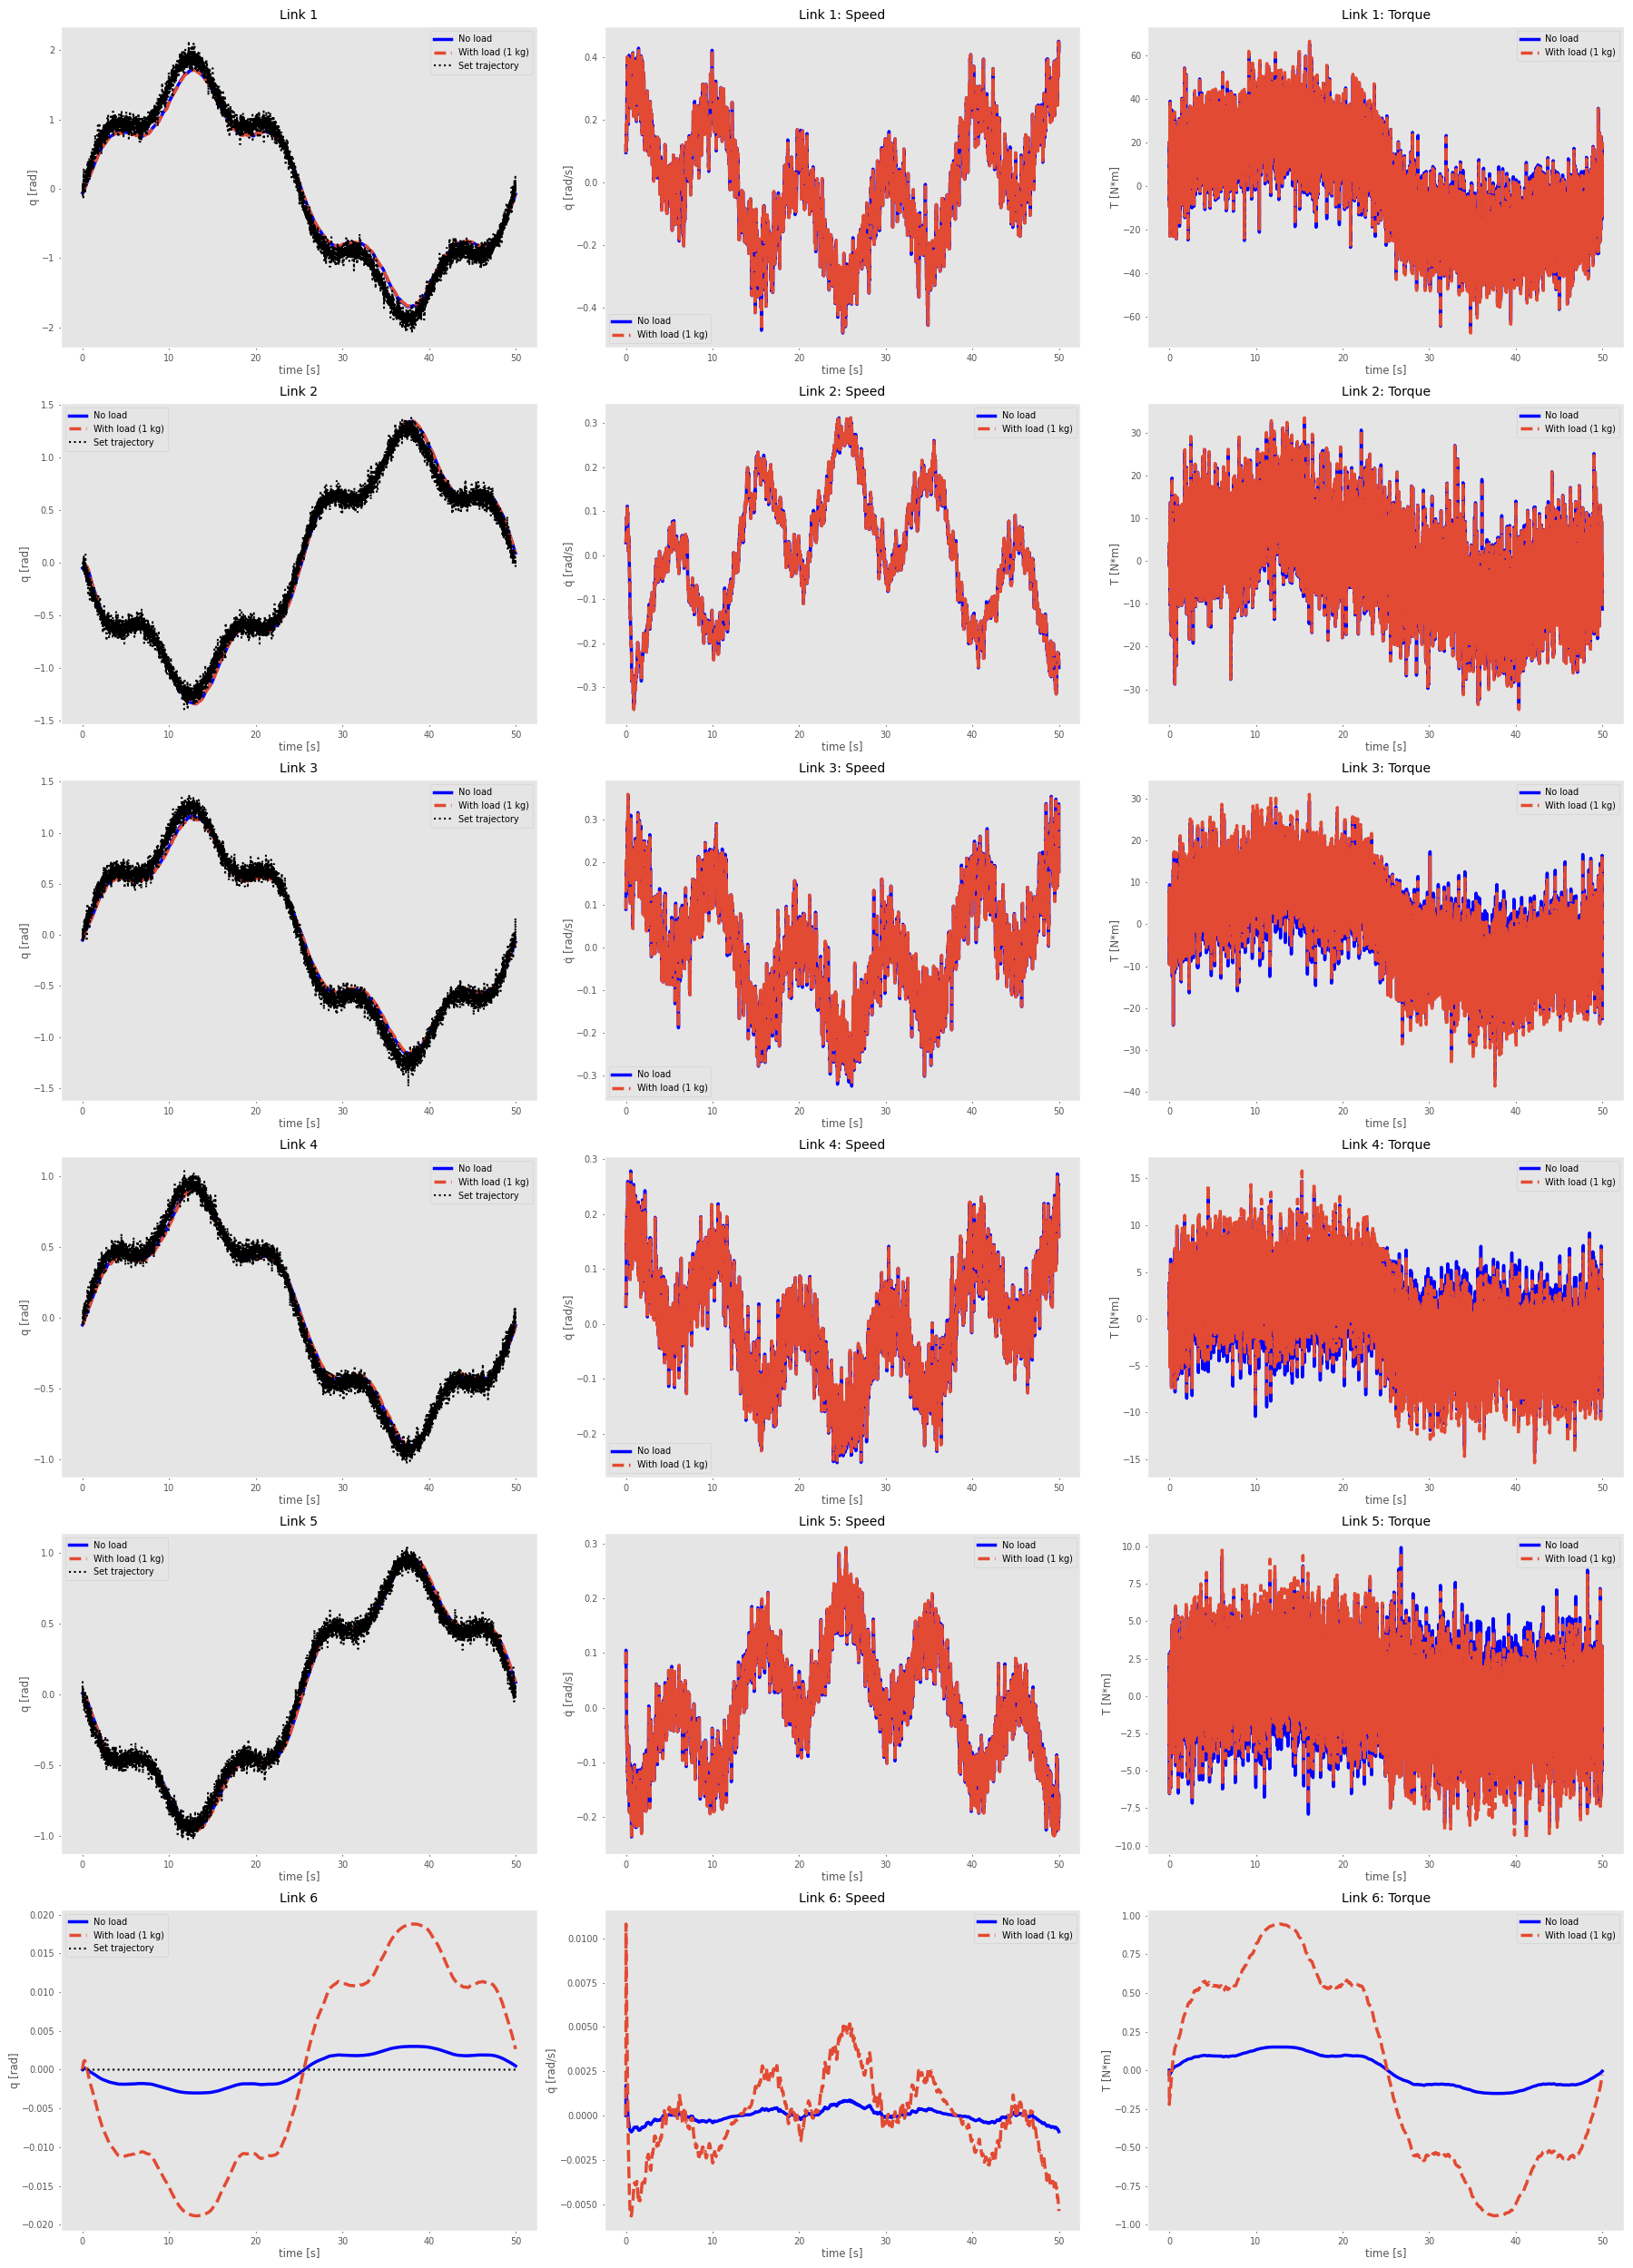

In [7]:
# --- Trajectory ---
traj = TrajectoryGenerator(q_start, q_end, steps)

# --- No load ---
robot_free = UR3Robot(payload_mass=0.0)
controller_free = RobotAppController(robot_free, traj, Kp, Kd)
q_free, qd_free, tau_free = controller_free.simulate()

# --- With load (1 kg) ---
robot_load = UR3Robot(payload_mass=1.0)
controller_load = RobotAppController(robot_load, traj, Kp, Kd)
q_load, qd_load, tau_load = controller_load.simulate()

# --- visualization ---

line_width = 2.5
t = np.linspace(0, steps*0.01, steps)
plt.figure(figsize=(18, 25))

for i in range(6):
    # Position graph
    plt.subplot(6, 3, i*3+1)
    plt.plot(t, q_free[:,i], 'b', label='No load', linewidth=line_width)
    plt.plot(t, q_load[:,i], '--', label='With load (1 kg)', linewidth=line_width)
    plt.plot(t, traj.q[:,i], 'k:', label='Set trajectory', linewidth=1.5)
    plt.title(f'Link {i+1}')
    plt.xlabel('time [s]')
    plt.ylabel('q [rad]')
    plt.grid()
    plt.legend()

    # График скорости
    plt.subplot(6, 3, i*3+2)
    plt.plot(t, qd_free[:,i],'b', label='No load', linewidth=line_width)
    plt.plot(t, qd_load[:,i], '--', label='With load (1 kg)', linewidth=line_width)
    plt.title(f'Link {i+1}: Speed')
    plt.xlabel('time [s]')
    plt.ylabel('q̇ [rad/s]')
    plt.grid()
    plt.legend()

    # График момента
    plt.subplot(6, 3, i*3+3)
    plt.plot(t[:-1], tau_free[:,i],'b', label='No load', linewidth=line_width)
    plt.plot(t[:-1], tau_load[:,i], '--', label='With load (1 kg)', linewidth=line_width)
    plt.title(f'Link {i+1}: Torque')
    plt.ylabel('T [N*m]')
    plt.xlabel('time [s]')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'self' is not defined

In [16]:
q_start = np.zeros(6)
q_end = np.array([pi/2, -pi/3, pi/3, pi/4, -pi/4, 0])
steps = 500
Kp = np.diag([150, 150, 120, 80, 60, 50])   
Kd = np.diag([50, 50, 40, 30, 25, 20])      


Error frame 0: 'UR3Robot' object has no attribute 'base'
Error frame 1: 'UR3Robot' object has no attribute 'base'
Error frame 2: 'UR3Robot' object has no attribute 'base'
Error frame 3: 'UR3Robot' object has no attribute 'base'
Error frame 4: 'UR3Robot' object has no attribute 'base'
Error frame 5: 'UR3Robot' object has no attribute 'base'
Error frame 6: 'UR3Robot' object has no attribute 'base'
Error frame 7: 'UR3Robot' object has no attribute 'base'
Error frame 8: 'UR3Robot' object has no attribute 'base'
Error frame 9: 'UR3Robot' object has no attribute 'base'
Error frame 10: 'UR3Robot' object has no attribute 'base'
Error frame 11: 'UR3Robot' object has no attribute 'base'
Error frame 12: 'UR3Robot' object has no attribute 'base'
Error frame 13: 'UR3Robot' object has no attribute 'base'
Error frame 14: 'UR3Robot' object has no attribute 'base'
Error frame 15: 'UR3Robot' object has no attribute 'base'
Error frame 16: 'UR3Robot' object has no attribute 'base'
Error frame 17: 'UR3Robo

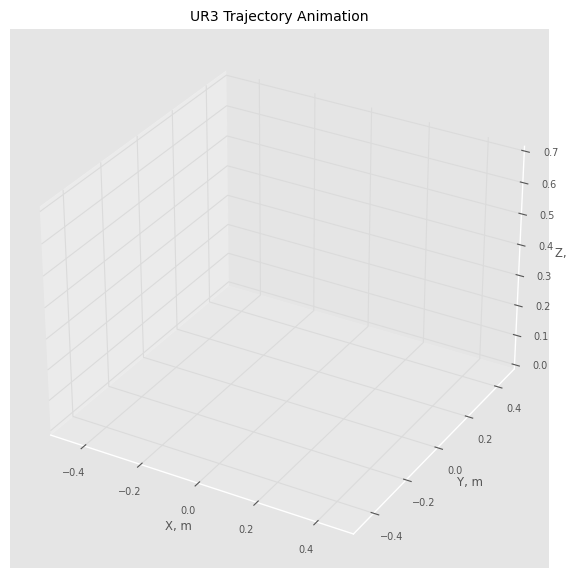

In [18]:
# q_hist — массив (steps, 6) с траекторией движения (например, результат симуляции контроллера)
# robot — объект UR3Robot или DHRobot, поддерживающий метод .fkine()
robot = UR3Robot()
traj = TrajectoryGenerator(q_start, q_end, steps)
controller = RobotAppController(robot, traj, Kp, Kd)
q_hist, qd_hist, tau_hist = controller.simulate(dt=0.01)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("UR3 Trajectory Animation")
ax.set_xlabel("X, m")
ax.set_ylabel("Y, m")
ax.set_zlabel("Z, m")

# Ограничения осей (по размеру рабочей зоны UR3)
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([0, 0.7])

# Для хранения линий звеньев
lines = []
for _ in range(6):
    line, = ax.plot([], [], [], 'o-', lw=3)
    lines.append(line)

def get_xyz_points(robot, q):
    """Compute positions of all joints manually"""
    points = []
    T = robot.base  # Start from base transformation
    
    # Accumulate transformations for each joint
    for i in range(robot.n):
        T = T * robot.A(i, q[i])
        points.append(T.t)
    
    # Add end-effector position
    points.append((T * robot.tool).t)
    return np.array(points)

def init():
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return lines

def animate(i):
    try:
        q = q_hist[i]
        xyz = get_xyz_points(robot, q)
        
        # Update joint connections
        for j in range(len(lines)):
            if j < len(xyz) - 1:
                xs = [xyz[j, 0], xyz[j+1, 0]]
                ys = [xyz[j, 1], xyz[j+1, 1]]
                zs = [xyz[j, 2], xyz[j+1, 2]]
                lines[j].set_data(xs, ys)
                lines[j].set_3d_properties(zs)
        return lines
    except Exception as e:
        print(f"Error frame {i}: {str(e)}")
        return lines

ani = animation.FuncAnimation(
    fig, animate, frames=len(q_hist), init_func=init, blit=True, interval=10
)

# Сохранение анимации как GIF
ani.save('ur3_trajectory.gif', writer='pillow', fps=30)

plt.show()